# Short term variations

## Introduction

I present here some preliminary results aimed at finding short time scale absorption line variations (~ minutes) likely caused by fast moving excomets close to the star (a few stellar radii). I have chosen to look at the far-UV SiIV doublet at 1394 and 1403 Å, because the exocometary variatons are evident, and the S/N is high for these lines, compared to other lines in the spectra. My hypothesis is that the emission originates from exocomets close to the star where the conditions for highly ionising Si are met.

## Aim
The aim is to look for short term variations. For this, I look at data taken during a single visit. In order to become sensitive to variations on the order of tens of minutes I have to divide the data into datasets of shorter exposuretimes. Fortunately this data is already available from the pipeline in fhe form of sumN.fits files, where N is an integer. I have been working with the \*sum[1..4].fits files where the average(*sum1.fits, *sum2.fits, *sum3.fits, *sum4.fits) = *sum.fits. This has the advantage that we have 4 times the number of spectra for a given visit at the cost of ~1/4 the exposure time.

## The code

The code written below uses functions in ```src/calculations.py```. It is capable of looking for variations in the entire dataset (e.g. it is capable of running over each HST visit).

### Import the standard routines

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

# get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions from src/calculations.py
from calculations import Calc

# We shorten the function name to make it easier to call the required a functions
c   = Calc()

Repository home directory: /home/pas/science/exocomets


### We now import the parameters used for the analysis

In [2]:
# Importing parameters from a json file.
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

In [3]:
# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# We select part A which is the red end of the spectrum (the othes part being B, which is the blue end)
part     = param["BetaPictoris"]["part"]

### Extract the data from fits files and save them as a npz file

In [4]:
D = []

print("Data used for this analysis:")

for i in sorted(datadirs):
    print("\n",datadirs[i])
    D.append(c.GetData(param, home+'/'+datadirs[i]))
    
# We save the data
np.savez(home+'/data/D_'+part+'.npz', D, dtype=object)

Data used for this analysis:

 data/2017-08-04/
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-08-04, Time: 14:31:03 UTC
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-08-04, Time: 14:43:00 UTC
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-08-04, Time: 14:54:57 UTC
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-08-04, Time: 15:06:54 UTC
	AVM shift: -1.1" 	EXP: 664s, 	Date: 2017-08-04, Time: 15:57:36 UTC
	AVM shift: -1.1" 	EXP: 664s, 	Date: 2017-08-04, Time: 16:11:13 UTC
	AVM shift: -1.1" 	EXP: 664s, 	Date: 2017-08-04, Time: 16:24:50 UTC
	AVM shift: -1.1" 	EXP: 664s, 	Date: 2017-08-04, Time: 16:38:27 UTC
	AVM shift: 1.1" 	EXP: 664s, 	Date: 2017-08-04, Time: 17:32:52 UTC
	AVM shift: 1.1" 	EXP: 664s, 	Date: 2017-08-04, Time: 17:46:29 UTC
	AVM shift: 1.1" 	EXP: 664s, 	Date: 2017-08-04, Time: 18:00:06 UTC

 data/2017-10-21/
	AVM shift: 0.0" 	EXP: 444s, 	Date: 2017-10-20, Time: 17:09:09 UTC
	AVM shift: 0.0" 	EXP: 444s, 	Date: 2017-10-20, Time: 16:59:03 UTC
	AVM shift: 0.0" 	EXP: 444s, 	Date: 2017-10-20, Time: 17:2

/usr/lib/python3.10/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


### We now normalise, shift and re-normalise the data 

In [5]:
# Load the data into the multidimentional array D
D = c.LoadData(home+'/data/D_'+part+'.npz')

# Normalise the data
Dn = c.NormSpec(param, D)

# Shift the data relative to the first spectrum of each visit
Dns = c.ShiftSpec(param, Dn)

# Re normalise the data
Dnsn = c.NormSpec(param, Dns)

# We save the normalised and shifted data
np.savez(home+'/data/Dnsn_'+part+'.npz', Dns, dtype=object)



Normalising the spectra relative to first spectrum...
Done



Shifting the 1st observation:


Observations done at: 2017-08-04 14:31:03
______________________________________________

 Pixel shift [pix]:	 0
 W shift [A]:		 0.0
 RV shift [km/s]:	 0
______________________________________________


Observations done at: 2017-08-04 14:43:00
______________________________________________

 Pixel shift [pix]:	 2
 W shift [A]:		 0.02
 RV shift [km/s]:	 4
______________________________________________


Observations done at: 2017-08-04 14:54:57
______________________________________________

 Pixel shift [pix]:	 5
 W shift [A]:		 0.05
 RV shift [km/s]:	 11
______________________________________________


Observations done at: 2017-08-04 15:06:54
______________________________________________

 Pixel shift [pix]:	 -3
 W shift [A]:		 -0.03
 RV shift [km/s]:	 -6
______________________________________________


Observations done at: 2017-08-04 15:57:36
___________________________________________

/home/pas/science/exocomets/src/calculations.py:289: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Dn)
/home/pas/science/exocomets/src/calculations.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Ds)


### Load the data into a matrix of arrays

In [6]:
# The structure here is
# DP[visit][orbit][0 = wavelength, 1 = flux, 2 = one sigma uncertainty, 3 = datetime]
DP   = c.LoadData(home+'/data/Dnsn_'+part+'.npz')

Let's have a look at when the spectra were obtained

## Inspecting the data

At this point we are dealing with more custom code and so it features here for clarity, and it not moved to ```src/calculations.py```.

In [7]:
# Setting the parameters for the plots
plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 22,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 22,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

In [8]:
# Parameters to be put into params.json
Line1 = 1393.7550 # The first SiIV line
Line2 = 1402.7700 # The second SiIV line

bin_size = 5 # Only for visualisation. Never used for calculation.

# Selecting a region for determening the baseline (normalsation region), e.g. flux = 0.
n1 = 400  # km/s
n2 = 1500 # km/s

cool=cm.plasma(np.linspace(0.0,0.9,len(DP[0]))) # Create some nice colours for the plot

Looking at observations done on:

 2017-08-04

 2017-10-20


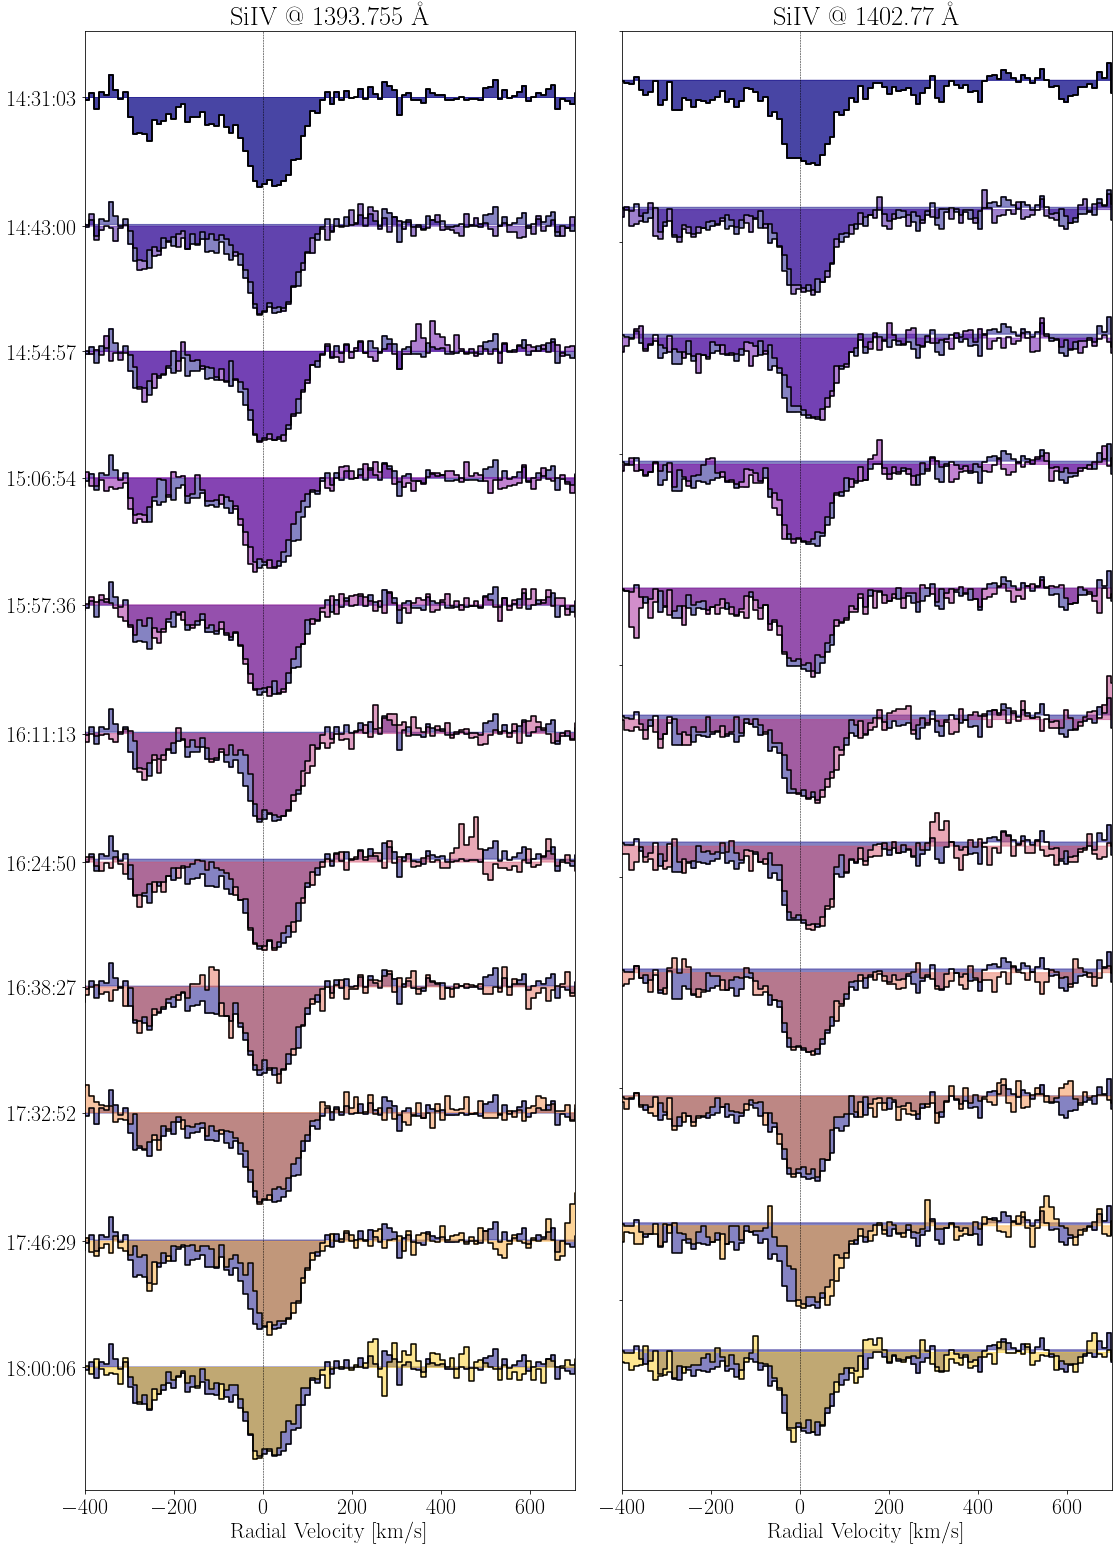

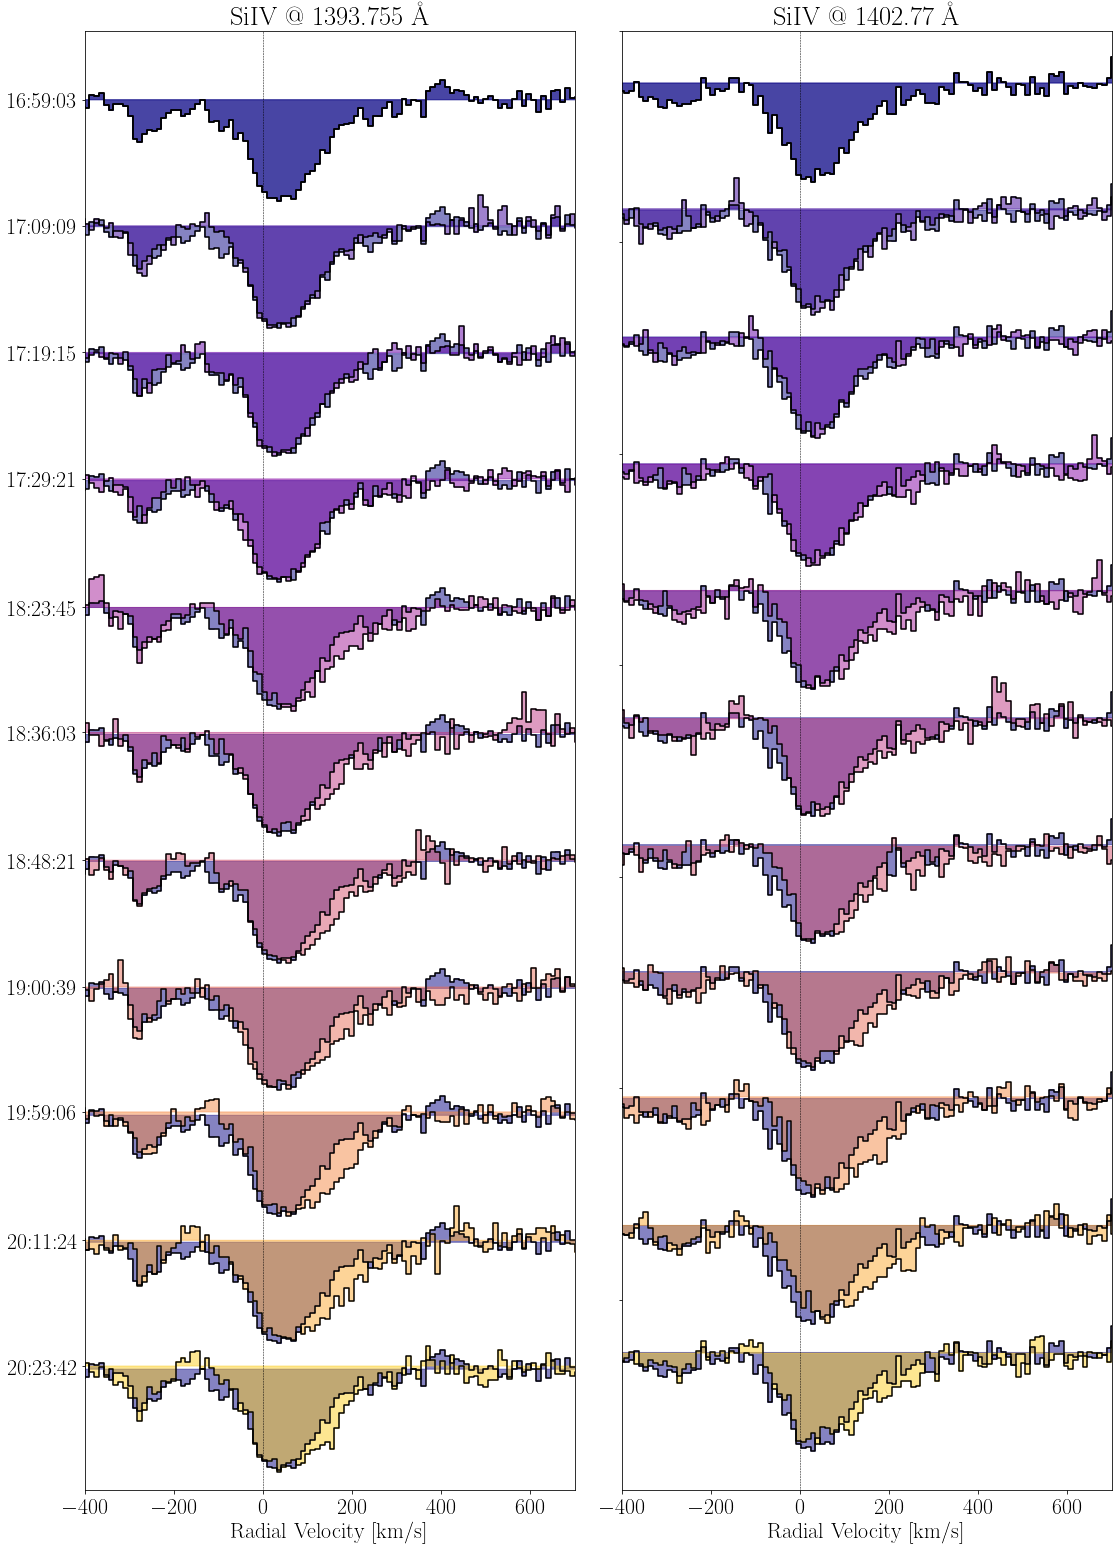

In [9]:
print('Looking at observations done on:')

# We loop over all the visits given in params.json
for nobs in range(len(DP)):
    
    # We extract the date so we can put it on the y-axis of the plot
    date = str(D[nobs][0][3])[:10]
    
    fig = plt.figure(figsize=(16.0,22.0))

    print('\n',date)
    
    ax1 = plt.subplot(121)
    
    rv = c.Wave2RV(DP[nobs][0][0],Line1,20.5) # Convert to RV space
    x, y = c.BinXY(rv,DP[nobs][0][1],bin_size) # Bin the data

    s1, s2 = c.RegionSelect(x, n1, n2)

    # Plot the vertical line at v = 0 km/s
    plt.plot([0,0],[-3.0e-12,0.5e-12],'--k',lw=0.5)

    ticks = []
    times = []

    # In this plot we want to compare each observation to the first one:
    x1, y1 = c.BinXY(rv,DP[nobs][0][1],bin_size)

    for i in range(len(DP[0])):
        offset = i*3e-13
        x, y = c.BinXY(rv,DP[nobs][i][1],bin_size)

        ticks.append(np.median(y[s1:s2])-offset)
        times.append(str(DP[nobs][i][3])[11:])

        plt.step(x1,y1-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x1,y1-offset,np.median(y1[s1:s2])*np.ones(len(x1))-offset,step='pre',color=cool[0],alpha=0.5)
        plt.step(x,y-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x,y-offset,np.median(y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)
     
    plt.xlabel(r'Radial Velocity [km/s]')
    plt.xlim(-400,700)
    plt.ylim(-2.95e-12,0.5e-12)
    plt.gca().set_yticks(ticks) 
    plt.gca().set_yticklabels(times)


    ax2 = plt.subplot(122)

    rv = c.Wave2RV(DP[nobs][0][0],Line2,20.5)
    x, y = c.BinXY(rv,DP[nobs][0][1],bin_size)

    s1, s2 = c.RegionSelect(x, n1, n2)

    plt.plot([0,0],[-3.0e-12,0.5e-12],'--k',lw=0.5)

    x1, y1 = c.BinXY(rv,DP[nobs][0][1],bin_size)

    for i in range(len(DP[nobs])):
        offset = i*3e-13
        x, y = c.BinXY(rv,DP[nobs][i][1],bin_size)

        ticks.append(np.median(y[s1:s2])-offset)
        times.append(str(DP[nobs][i][3])[11:])

        plt.step(x1,y1-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x1,y1-offset,np.median(y1[s1:s2])*np.ones(len(x1))-offset,step='pre',color=cool[0],alpha=0.5)
        plt.step(x,y-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x,y-offset,np.median(y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)

    plt.xlabel(r'Radial Velocity [km/s]')

    ax2.set(yticklabels=[]) 
    ax2.set(ylabel=None)     

    plt.xlabel(r'Radial Velocity [km/s]')
    plt.xlim(-400,700)
    plt.ylim(-2.95e-12,0.5e-12)
    ax1.title.set_text('SiIV @ '+str(Line1)+' \AA')
    ax2.title.set_text('SiIV @ '+str(Line2)+' \AA')
    fig.tight_layout()
    plt.savefig(home+'/plots/'+date+'.pdf', bbox_inches='tight', pad_inches=0.1,dpi=300)

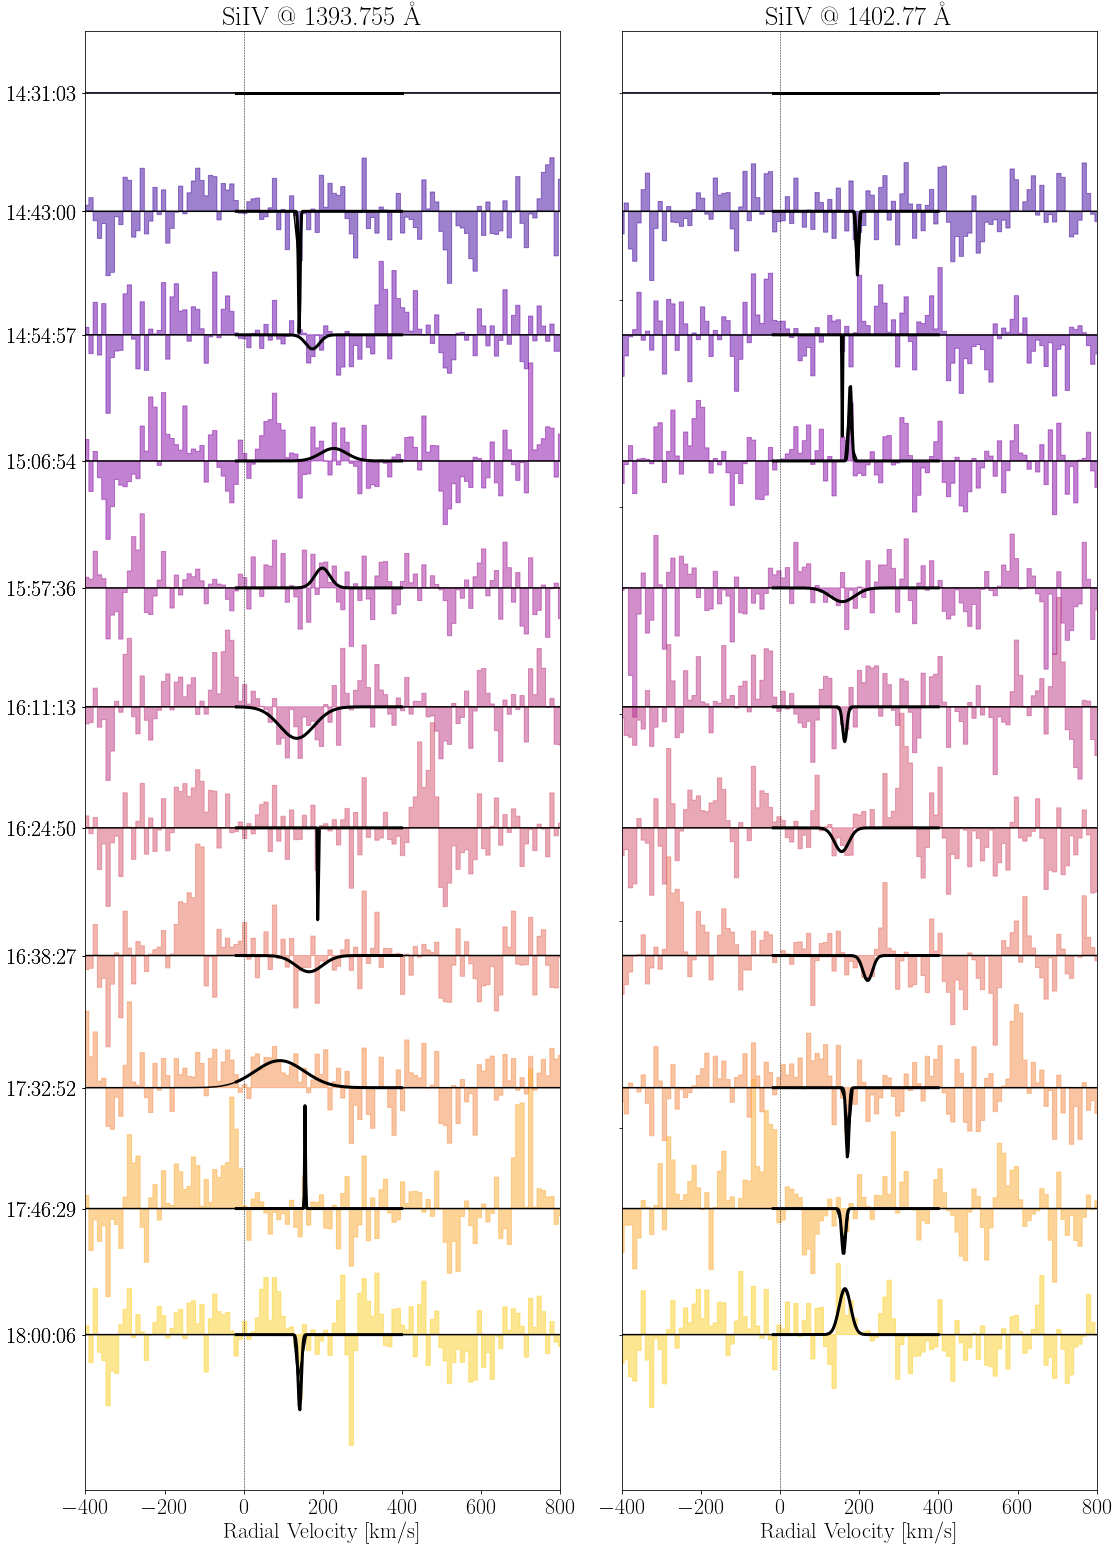

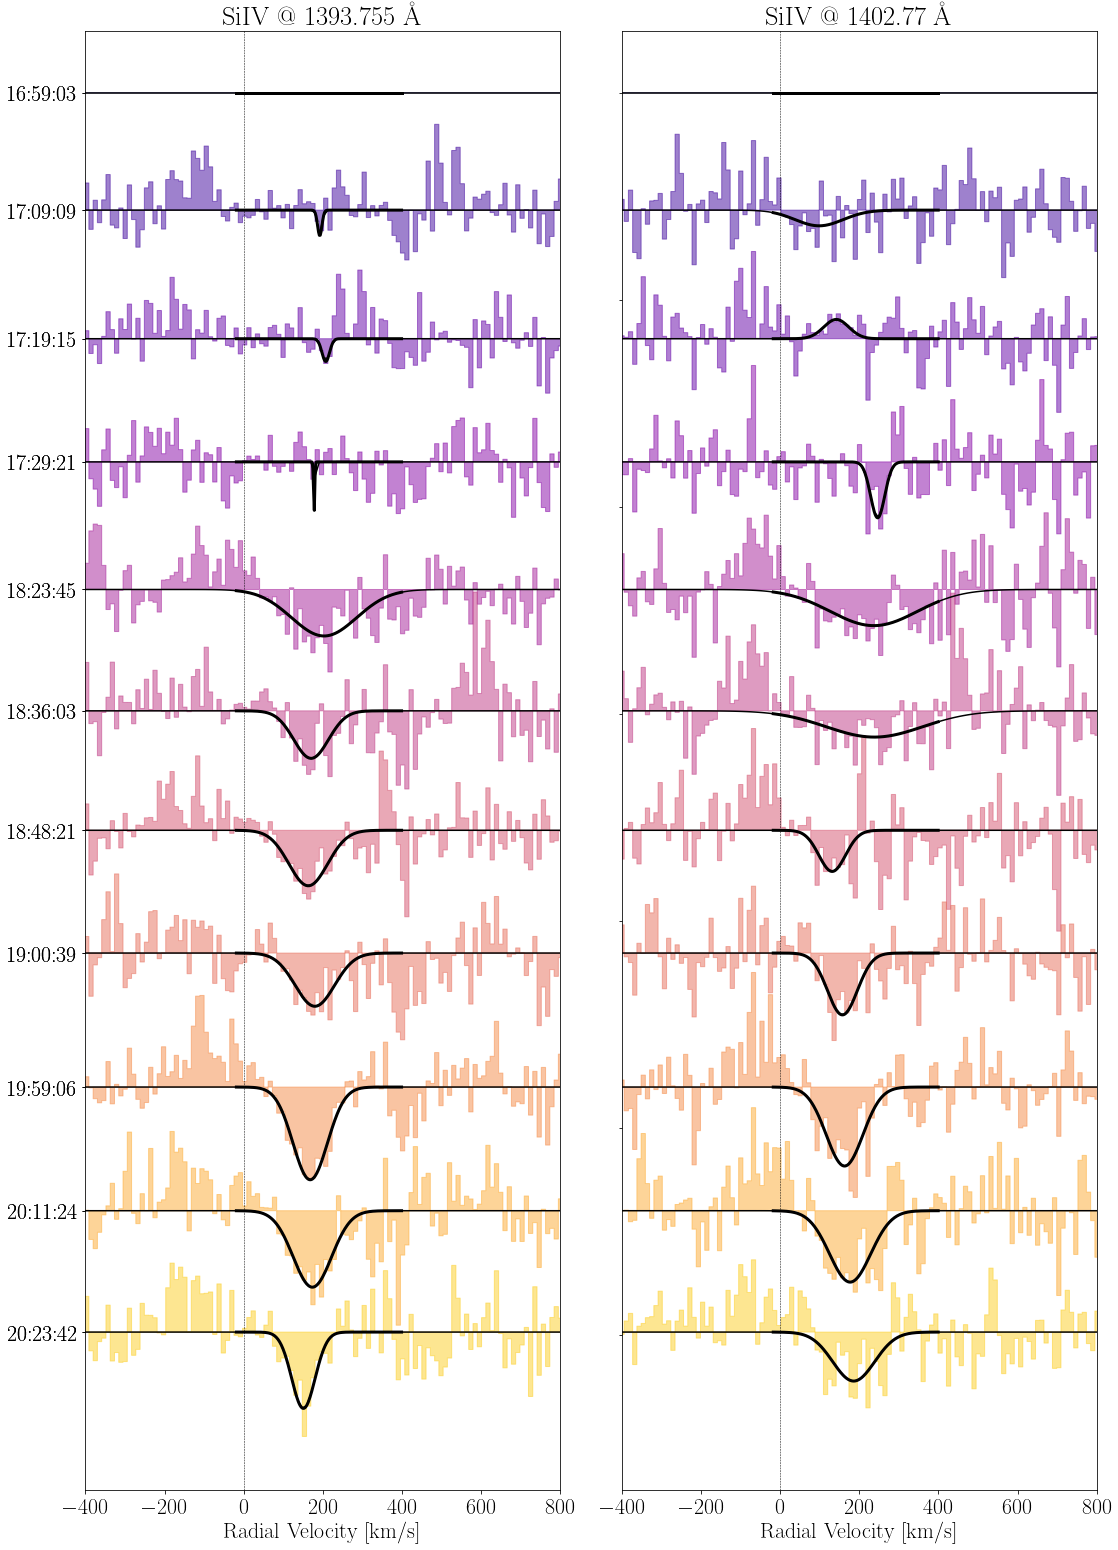

In [15]:
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma):
    return -a*np.exp(-(x-x0)**2/(2*sigma**2))

bin_size = 5

lines = [1393.7550, 1402.7700]

g1 = -20
g2 = 400


amplitude = np.zeros(shape=(len(DP),2, len(DP[nobs])))
shift = np.zeros(shape=(len(DP),2, len(DP[nobs])))
width = np.zeros(shape=(len(DP),2, len(DP[nobs])))

amplitude_err = np.zeros(shape=(len(DP),2, len(DP[nobs])))
shift_err = np.zeros(shape=(len(DP),2, len(DP[nobs])))
width_err = np.zeros(shape=(len(DP),2, len(DP[nobs])))

diffg = np.zeros(shape=(len(DP),2, len(DP[nobs])))

# Run a loop over the number of visits
for nobs in range(len(DP)):
    fig = plt.figure(figsize=(16.0,22.0))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.plot([0,0],[-3.2e-12,0.5e-12],'--k',lw=0.5)
    ax2.plot([0,0],[-3.2e-12,0.5e-12],'--k',lw=0.5)
    
    date = str(D[nobs][0][3])[:10]
    
    # The spectrum we are comparing to
    x, y = c.BinXY(rv,DP[nobs][0][1],bin_size)
    s1, s2 = c.RegionSelect(x, n1, n2)
      
    ticks = []
    times = []

    x1, y1 = c.BinXY(rv,DP[nobs][0][1],bin_size)
    
    
    # Run a loop over the number of lines being explored.
    # In this case the 1393.7550 and 1402.7700 lines
    for j in range(2):
        
        rv = c.Wave2RV(DP[nobs][0][0],lines[j],20.5)
        
        # Select the region which will be used for fitting the Gaussian
        gg1, gg2 = c.RegionSelect(rv, g1, g2)
        
        # Run a loop over each exposure
        for i in range(len(DP[nobs])):
            offset = i*1.2e-13#/ 2.5e-13
            
            # Next spectrum
            x, y = c.BinXY(rv,DP[nobs][i][1],bin_size)

            ticks.append(np.median(y1[s1:s2]-y[s1:s2])-offset)
            times.append(str(DP[nobs][i][3])[11:])
            
            # Calculate the difference between the spectra
            diffg = (DP[nobs][i][1]-DP[nobs][0][1])[gg1:gg2]
            xg = rv[gg1:gg2]
            
            # Fit a Gaussian to the data
            popt,pcov = curve_fit(gauss,xg,diffg,p0=[5e-14,180,20],bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))
            
            # Calculate the uncertainties on the parameters
            perr = np.sqrt(np.diag(pcov))
            
            # Store the fit parameters
            amplitude[nobs][j][i] = popt[0]
            shift[nobs][j][i] = popt[1]
            width[nobs][j][i] = popt[2]

            # Store the uncertainties on the parameters
            amplitude_err[nobs][j][i] = perr[0]
            shift_err[nobs][j][i] = perr[1]
            width_err[nobs][j][i] = perr[2]

            if j == 0:
                ax1.plot(x,gauss(x,*popt)+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,'-k')
                ax1.plot(xg,gauss(xg,*popt)+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(xg))-offset,'-k',lw=3)
                ax1.fill_between(x,y-y1+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)
            if j == 1:
                ax2.plot(x,gauss(x,*popt)+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,'-k')
                ax2.plot(xg,gauss(xg,*popt)+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(xg))-offset,'-k',lw=3)
                ax2.fill_between(x,y-y1+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)

    ax1.title.set_text('SiIV @ '+str(Line1)+' \AA')
    ax1.set_xlim(-400,800)
    ax1.set_ylim(-1.35e-12,6.0e-14)
    ax1.set_xlabel(r'Radial Velocity [km/s]')
    ax1.set_yticks(ticks) 
    ax1.set_yticklabels(times)
    
    ax2.title.set_text('SiIV @ '+str(Line2)+' \AA')
    ax2.set_xlim(-400,800)
    ax2.set_ylim(-1.35e-12,6.0e-14)
    ax2.set_xlabel(r'Radial Velocity [km/s]')
    ax2.set(yticklabels=[]) 
    ax2.set(ylabel=None)  
    
    
    fig.tight_layout()
    plt.savefig(home+'/plots/'+date+'_exocomets.pdf', bbox_inches='tight', pad_inches=0.1,dpi=300)

Date: 2017-08-04
	 1393.755
Amplitude:	 p_value = 0.615
Shift:		 p_value = 0.174
Width:		 p_value = 0.488
	 1402.77
Amplitude:	 p_value = 0.569
Shift:		 p_value = 0.701
Width:		 p_value = 0.579

Date: 2017-10-20
	 1393.755
Amplitude:	 p_value = 0.0
Shift:		 p_value = 0.112
Width:		 p_value = 0.044
	 1402.77
Amplitude:	 p_value = 0.004
Shift:		 p_value = 0.886
Width:		 p_value = 0.568



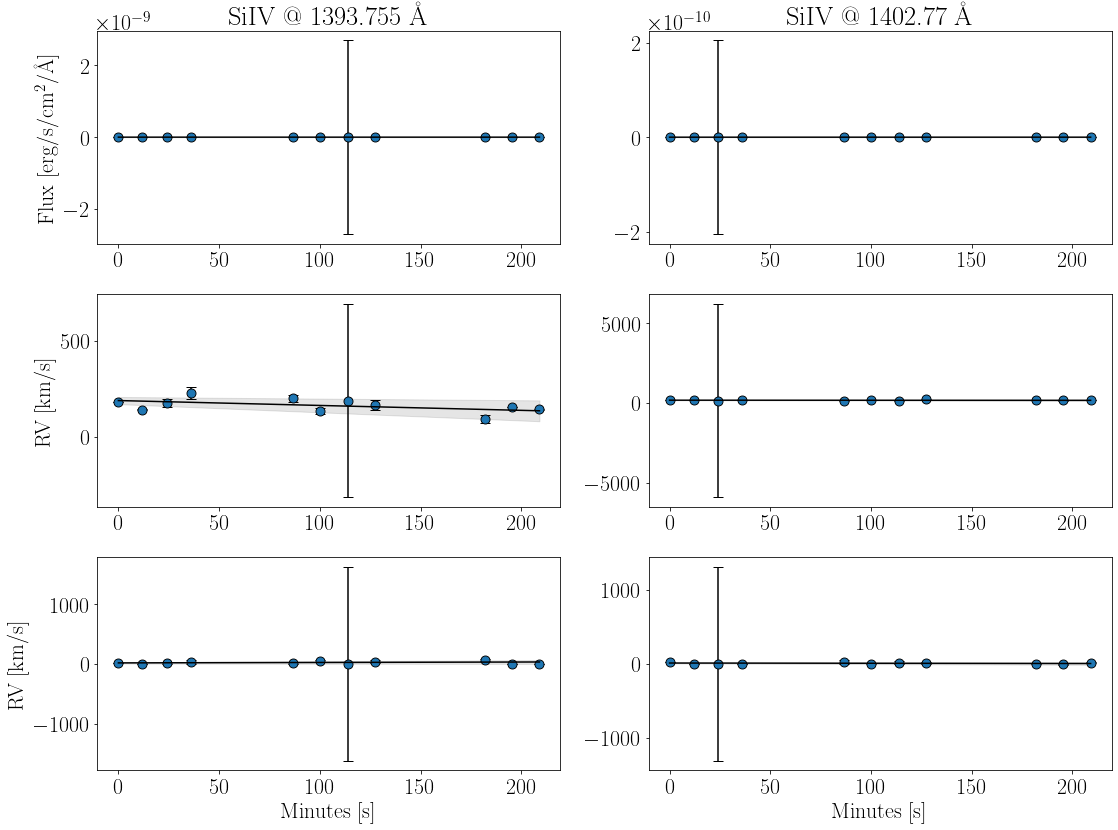

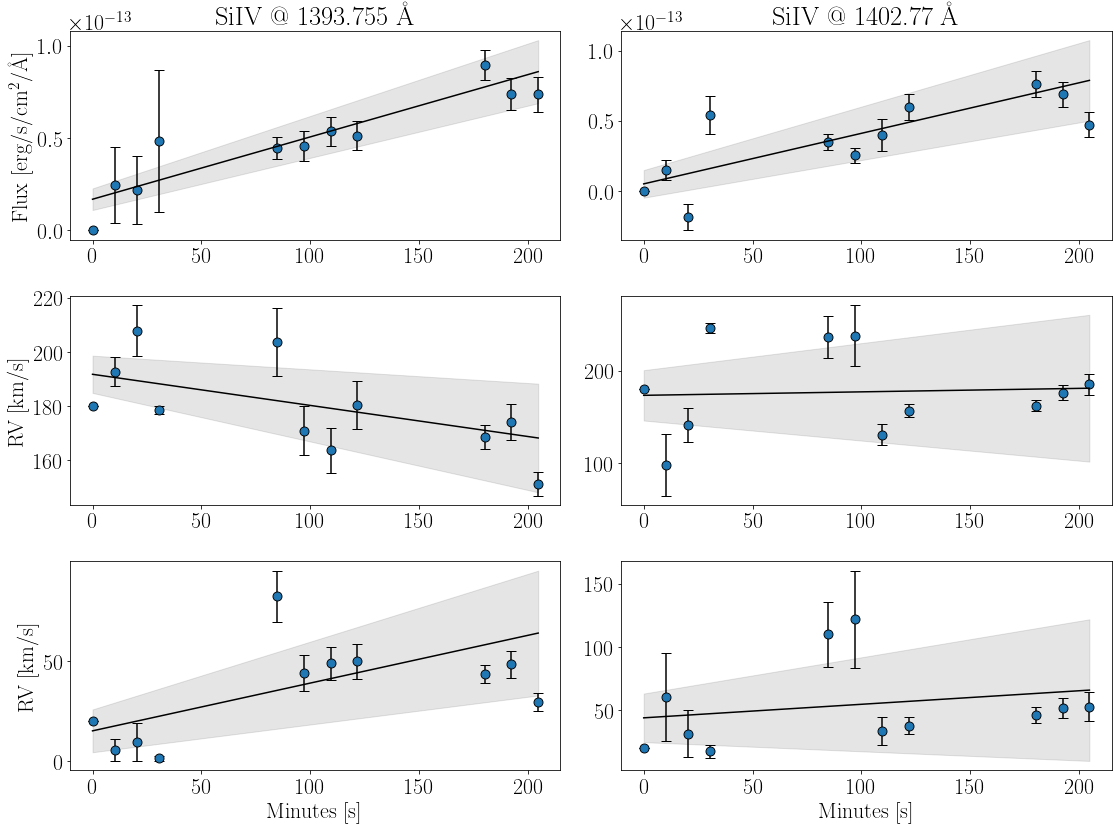

In [16]:
from datetime import timedelta
from scipy.stats import linregress


minutes = np.zeros(shape=(len(DP),len(DP[nobs])))


#fig = plt.figure(figsize=(16.0,22.0))

plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 22,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 22,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

for nobs in range(len(DP)):
    date = str(D[nobs][0][3])[:10]
    print("Date:",date)
    print(32*"=")
    
    #3 rows and 2 columns
    fig, axes = plt.subplots(3, 2, figsize=(16,12))  
    
    for i in range(len(DP[nobs])):
        times = str(DP[nobs][i][3])[11:]
        delta = timedelta(hours=int(times.split(':')[0]), minutes=int(times.split(':')[1]), seconds=int(times.split(':')[2]))
        minutes[nobs][i] = delta.total_seconds()/60

    minutes[nobs] = minutes[nobs]-minutes[nobs][0]

    for j in range(2):
        
        res1 = linregress(minutes[nobs][:-1], amplitude[nobs][j][:-1])
        axes[0][j].fill_between(minutes[nobs],(res1.slope+res1.stderr)*minutes[nobs]+res1.intercept+res1.intercept_stderr,(res1.slope-res1.stderr)*minutes[nobs]+res1.intercept-res1.intercept_stderr,color="black",alpha=0.1)
        axes[0][j].errorbar(minutes[nobs],amplitude[nobs][j],yerr=amplitude_err[nobs][j],capsize=5,ls="None",color="black")
        axes[0][j].scatter(minutes[nobs],amplitude[nobs][j],s=80,zorder=2,color="black")
        axes[0][j].scatter(minutes[nobs],amplitude[nobs][j],s=50,zorder=2,label="Absorption depth")
        axes[0][j].plot(minutes[nobs],res1.slope*minutes[nobs]+res1.intercept,color="black")
        #axes[0][j].set_ylim(0.2e-13,3.0e-13)

        res2 = linregress(minutes[nobs][:-1], shift[nobs][j][:-1])
        axes[1][j].fill_between(minutes[nobs],(res2.slope+res2.stderr)*minutes[nobs]+res2.intercept+res2.intercept_stderr,(res2.slope-res2.stderr)*minutes[nobs]+res2.intercept-res2.intercept_stderr,color="black",alpha=0.1)
        axes[1][j].errorbar(minutes[nobs],shift[nobs][j],yerr=shift_err[nobs][j],capsize=5,ls="None",color="black")
        axes[1][j].scatter(minutes[nobs],shift[nobs][j],s=80,zorder=2,color="black")
        axes[1][j].scatter(minutes[nobs],shift[nobs][j],s=50,zorder=2,label="Absorption depth")
        axes[1][j].plot(minutes[nobs],res2.slope*minutes[nobs]+res2.intercept,color="black")
        #axes[1][j].set_ylim(150,220)      

        res3 = linregress(minutes[nobs][:-1], width[nobs][j][:-1])
        axes[2][j].fill_between(minutes[nobs],(res3.slope+res3.stderr)*minutes[nobs]+res3.intercept+res3.intercept_stderr,(res3.slope-res3.stderr)*minutes[nobs]+res3.intercept-res3.intercept_stderr,color="black",alpha=0.1)
        axes[2][j].errorbar(minutes[nobs],width[nobs][j],yerr=width_err[nobs][j],capsize=5,ls="None",color="black")
        axes[2][j].scatter(minutes[nobs],width[nobs][j],s=80,zorder=2,color="black")
        axes[2][j].scatter(minutes[nobs],width[nobs][j],s=50,zorder=2,label="Absorption depth")
        axes[2][j].plot(minutes[nobs],res3.slope*minutes[nobs]+res3.intercept,color="black")
        #axes[2][j].set_ylim(20,80)
        
        print("\t",lines[j])
        print('Amplitude:\t p_value =',round(res1.pvalue,3))
        print('Shift:\t\t p_value =',round(res2.pvalue,3))
        print('Width:\t\t p_value =',round(res3.pvalue,3))

        
        #with open(home+'/data/variations_'+date+'.txt', 'w') as output:
        #    output.write('Amplitude:\t p_value = '+str(round(res1.pvalue,3))+'\n')
        #ax1.set_ylim(0,50)
        #
    axes[0][0].set_ylabel(r'Flux [erg/s/cm$^2$/\AA]')
    axes[0][0].title.set_text('SiIV @ '+str(Line1)+' \AA')
    axes[0][1].title.set_text('SiIV @ '+str(Line2)+' \AA')
    axes[1][0].set_ylabel(r'RV [km/s]')
    axes[2][0].set_ylabel(r'RV [km/s]')
    axes[2][0].set_xlabel(r'Minutes [s]')
    axes[2][1].set_xlabel(r'Minutes [s]')
    fig.tight_layout()
    plt.savefig(home+'/plots/'+date+'_gaussian_parameters.pdf', bbox_inches='tight', pad_inches=0.1,dpi=300)
    print(32*"=","\n")